# The Impact of COVID-19 on Public Transport in the Greater Sydney Region 
# Visual Analysis
## Group 63
* Thomas Hall: 46495193
* Sam Huynh: 45431507
* Kavindu Nilhan Rankothge: 46172106
* Nehan Irushika Senevirathna: 45848009

## Introduction
The novel coronavirus, which started rising towards the beginning of January and has spread across the world, has had a massive impact on Australia. Our project aims to investigate how the public transport system in Sydney was impacted by COVID-19 during this pandamic. This notebook will focus on the visual analysis of our project and will include, investigating our data and finding other interesting relationships between the datasets by drawing various graphs.

Project Goals for the Visual Analysis
* Did lockdown regulations have a negative impact on the use of public transport?
* Which mode of public transport had a greater decrease in usage over the pandemic period?
* Understanding trends between different regions and looking for relationships between public transport usage and socio-economic status

## Our Data
#### Opal Data
We will use the Patronage tap on and tap off data from Open Data Transport NSW for the last 12 months for Chatswood, Macquarie Park, North Sydney, Parramatta, Strathfield and Sydney CBD
#### Covid Data
From Data NSW we will analyse the COVID-19 cases throughout NSW which includes details on the total number of cases for each day as well as the postcode in which these cases were recorded.
#### Socio-Economic Data
From the Australian Bureau of Statistics, we will use the Socio-Economic Indexes for Areas data for analysis of the socio-economic statuses of the 6 areas of Sydney mentioned above.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['figure.figsize'] = 15, 12

## Reading and Preprocessing The Data

The two files containing information on covid 19 cases and Opal public transport are read and assigned to different data frames. The column headers for the data frames will be assigned too.

In [2]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

In [3]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

Since the tap on and tap off data is stored as string objects we will convert them to integer type so that we can do numerical calculations and draw visual graphs from them.

In [4]:
#change values in tap on and tap off columns as just integers
opal_df.tap_on = opal_df.tap_on.str.replace(r'\D','').astype(int)
opal_df.tap_off = opal_df.tap_off.str.replace(r'\D','').astype(int)

## Starting Analysis
### Exploring the Opal Data
We will investigate how our opal data frame varies throughout the time period and try to find any interesting relationships or other ways of making our data easier to understand.

We can calculate the combined taps in the Opal data frame by adding the tap on and tap off data. Using combined taps in our analysis will help us get more accurate results since it involves both the indicators.

In [5]:
#Adding an additional column for combined tap ons and tap offs
opal_df['combined_taps'] = opal_df.apply(lambda row: row.tap_on + row.tap_off, axis=1)

Since our investigation in the project proposal focuses on the metropolitan area we will be dropping all other regions other than Chatswood, Macquarie Park, North Sydney, Parramatta, Strathfield and Sydney CBD.

In [6]:
#Dropping all regions outside of the metropolitan area
opal_df = opal_df[opal_df.region.isin(['Chatswood', 'Macquarie Park', 'North Sydney',  'Parramatta', 'Strathfield','Sydney CBD'])]

Finally, the Opal data frame will be grouped by data, mode type and region while the total sum of combined taps are recorded.

In [7]:
#Grouping opal data by day, type of transport and region
grouped_opal = opal_df.groupby(['date', 'mode_type', 'region']).sum()
grouped_opal.reset_index(inplace = True)

Drawing a graph comparing the use of public transport by region:

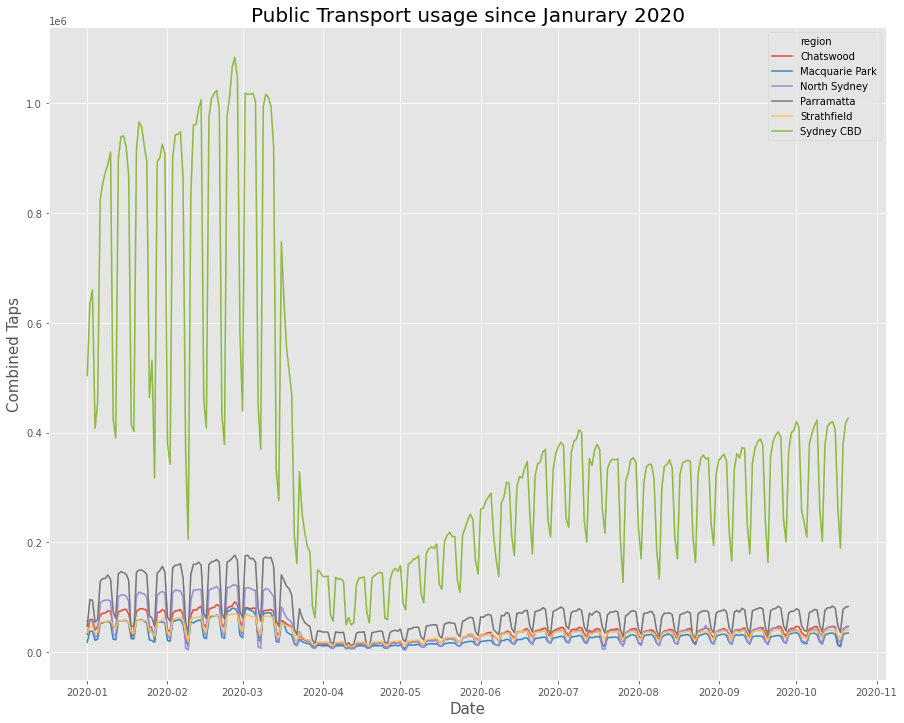

In [10]:
#General overview of public transport depending on the region 
plt.title("Public Transport usage since Janurary 2020", fontsize=20)
sns.lineplot(x= 'date', y='combined_taps',data=grouped_opal, hue = 'region', ci=False,estimator=sum) 
plt.ylabel("Combined Taps",fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.show()

From a quick glance, this graph only shows the total number of taps for each region and how they have changed over the course of the pandemic. As we can see here, it appears that the CBD and Chatswood have continued to have the highest number of public transport usage over the pandemic period. 

However, we can see a lot of Noise in this graph. This is because the graph is comparing the combined taps for each date. Therefore there will be a large variance throughout the week since towards the weekends there will be a sharp decrease in public transport usage usually.

The best way to reduce this Noise is by calculating the previous 14-day average. This can be done using Python's rolling average function. Now we can draw the same graph to see how it has changed.

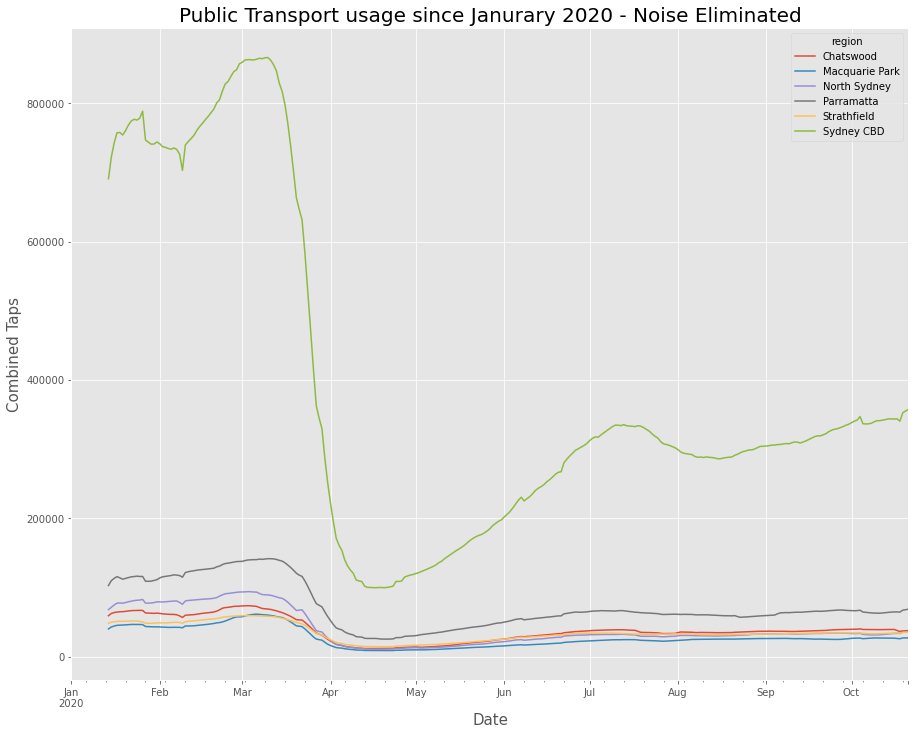

In [9]:
#Overview of transport usage by eliminating noise and using previous days average
smoothed_grouped_opal = grouped_opal.groupby(['date', 'region']).sum()['combined_taps'].unstack().rolling(window=14).mean()
smoothed_grouped_opal.plot().set_ylabel('Combined Taps',fontsize=15)
plt.title("Public Transport usage since Janurary 2020 - Noise Eliminated", fontsize=20)
plt.xlabel("Date",fontsize=15)
plt.show()

Here we have the same graph as above however, there has been a smoothening of the lines which makes it much easier to see that Sydney CBD and Chatswood have the highest public transport usage. This is mainly due to calculating the previous 14-day average which has eliminated the noise from the previous graph. Therefore, it would be more useful to use this rolling average in the future for other analysis in our project.

Investigating Public transport usage within all of Sydney:

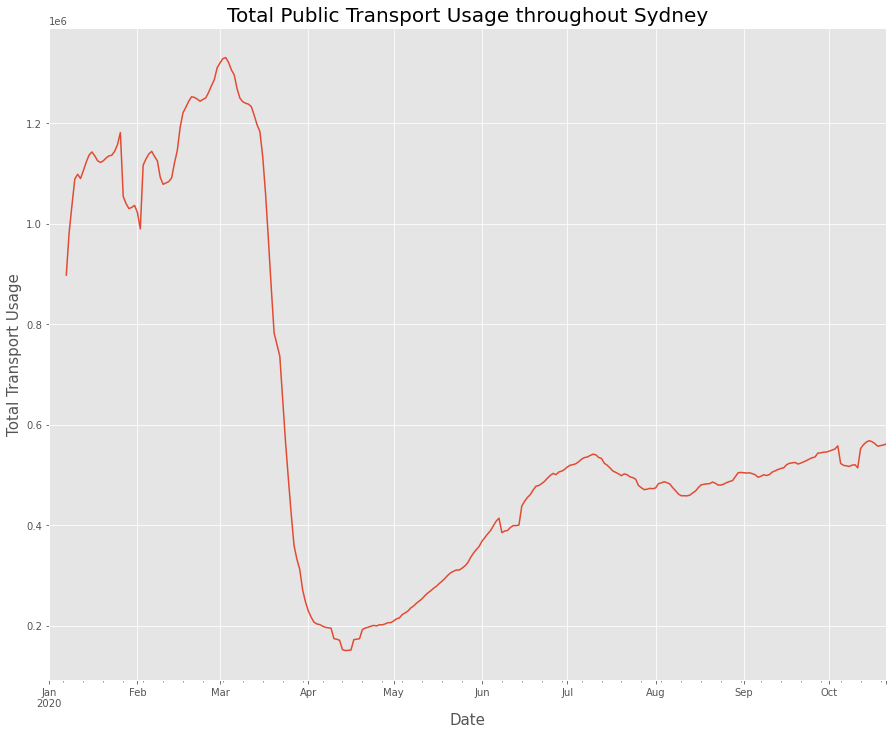

In [62]:
smoothed_total_opal = grouped_opal.groupby(['date']).sum()['combined_taps'].rolling(window=7).mean()
smoothed_total_opal.plot().set_ylabel('Total Transport Usage',fontsize=15)
plt.title("Total Public Transport Usage throughout Sydney", fontsize=20)
plt.xlabel("Date",fontsize=15)
plt.show()

### Exploring the Covid Data
We will investigate the covid data frame. Will be looking at ways to remove unwanted data while making it easier to interpret. Finally will look over any relationships by drawing visual graphs.

Selecting only the useful columns from the data frame:

In [12]:
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]

Isolating the locally transmitted covid-19 cases from the total cases which included the Overseas Cases. Can use this to investigate any differences between them.

In [13]:
#counting total cases by day and splitting into local and overseas sources
total_cases = covid_df.groupby('date').size()
local_covid_df = covid_df[covid_df['source'] != 'Overseas']
local_cases = local_covid_df.groupby('date').size()
local_cases = local_cases.reindex(pd.date_range(local_cases.index[0], local_cases.index[-1]), fill_value=0)
total_cases = total_cases.reindex(pd.date_range(total_cases.index[0], total_cases.index[-1]), fill_value=0)

Drawing a line graph comparing the locally acquired cases vs total cases in NSW through the time period to find any interesting relationships.

Text(0.5, 0, 'Date')

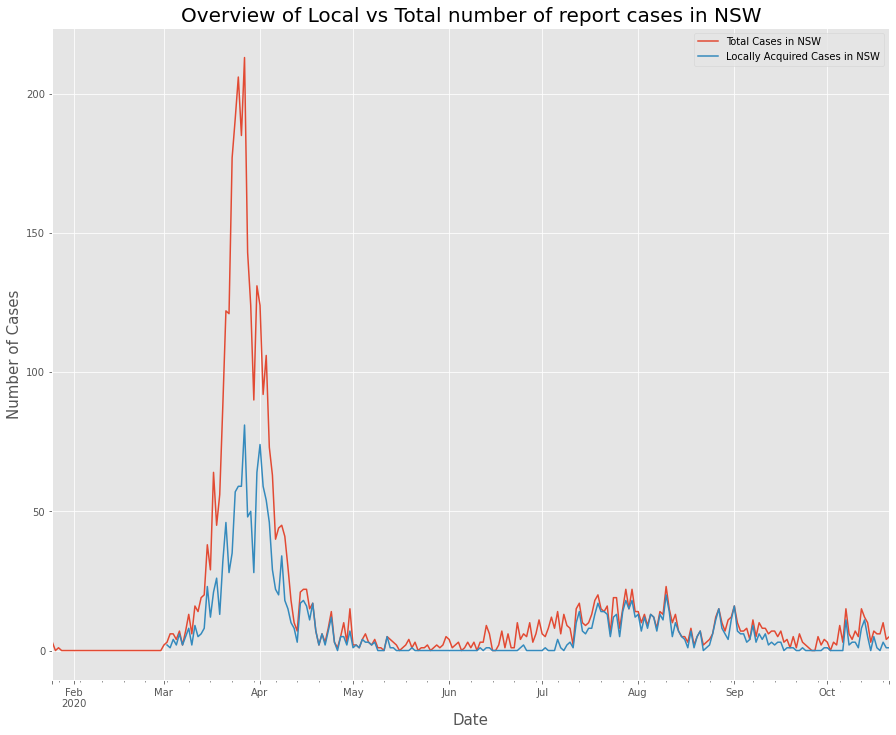

In [59]:
fig, ax = plt.subplots()
total_cases.plot(ax=ax)
local_cases.plot(ax=ax)
ax.legend(['Total Cases in NSW', 'Locally Acquired Cases in NSW'])
plt.title("Overview of Local vs Total number of report cases in NSW", fontsize=20)
ax.set_ylabel('Number of Cases',fontsize=15)
ax.set_xlabel('Date',fontsize=15)

From the above graph, we see a large rise in the number of covid cases from March. After reaching its peak towards the end of April, there is now a large decline until May. From then onwards the number of covid cases are constant until there is a smaller peak to the end of Jully.

As for the local and total cases, we can conclude that both of them follow a similar pattern during the time period. The main difference is that there is a much larger rise in Total cases compared to local cases between March and May. This graph too can benefit from noise reduction to help it easier to interpret.

Finally, it would be interesting to find any relationships when we overlay the number of covid cases graph with the Opal public transport usage graph. Both will be using rolling averages to reduce noise.

Text(0, 0.5, 'Number of Cases')

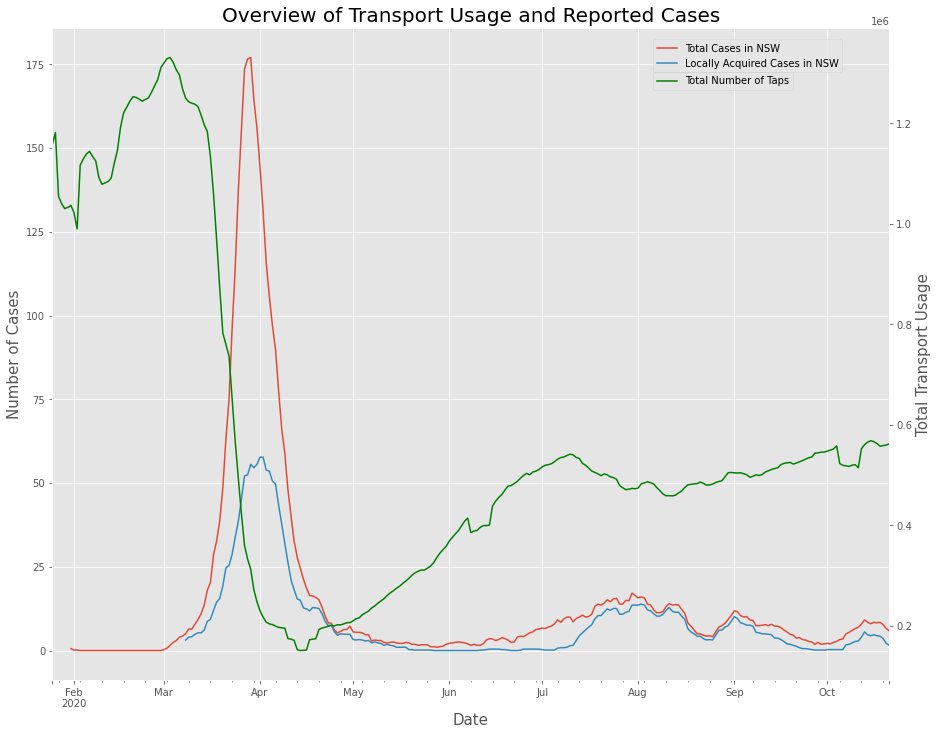

In [58]:
#Looking into the reaction of transport usage as the number of cases increased, smoothen over 7 day average
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title("Overview of Transport Usage and Reported Cases", fontsize=20)
smoothed_total_opal.plot(x = 'date', y = 'combined_taps', ax=ax2, color = 'green')
total_cases.rolling(window=7).mean().plot(ax=ax1)
local_cases.rolling(window=7).mean().plot(ax=ax1)
ax2.grid(None)
ax1.legend(['Total Cases in NSW', 'Locally Acquired Cases in NSW'], bbox_to_anchor=(0.95, 0.99))
ax2.legend(['Total Number of Taps'], bbox_to_anchor=(0.891, 0.94))
ax1.set_xlabel('Date', fontsize=15)
ax2.set_ylabel('Total Transport Usage', fontsize=15)
ax1.set_ylabel('Number of Cases', fontsize=15)

The above graph shows a quick overview of the relationship between the number of reported cases throughout NSW and the total number of public transport usage throughout NSW. It is clear from this graph that as soon as there was an increase in the number of reported cases, there is a sudden decrease in the total number of people using public transport.

### Analysing the impact of lockdown regulations on the use of public transport
One of our project proposal goals is to see if the lockdown regulations imposed by the government has had any impact on the usage of public transport. We can use the above-drawn graph that shows the public transport usage overlayed by the number of covid cases during the time period as a good way of demonstrating this.

Key events during the pandemic will be marked on the graph.

#### Key Events:
* The first case in Australia: 2020-01-25
* First Death in Australia: 2020-03-01
* Covid19 Declared as a Pandemic by WHO: 2020-03-11
* Lockdown regulations imposed by NSW government: 2020-03-21
* Social distancing eased: 2020-05-15
* NSW Crossroads Hotel outbreak: 2020-07-14

Assign new ‘smooth’ data frames to covid and opal data that use rolling averages so we can draw visual graphs with lesser noise.

In [50]:
smoothed_total_opal.dropna(inplace=True)
smoothed_total_opal = pd.DataFrame(smoothed_total_opal)
smoothed_total_opal.reset_index(inplace=True)

smoothed_total_cases = total_cases.rolling(window=7).mean()
smoothed_local_cases = local_cases.rolling(window=7).mean()
smoothed_total_cases = pd.DataFrame(smoothed_total_cases)
smoothed_local_cases = pd.DataFrame(smoothed_local_cases)
smoothed_total_cases.reset_index(inplace=True)
smoothed_local_cases.reset_index(inplace=True)
smoothed_total_cases.columns = ['date', 'cases']
smoothed_local_cases.columns = ['date', 'cases']

Drawing the final overlayed graph:

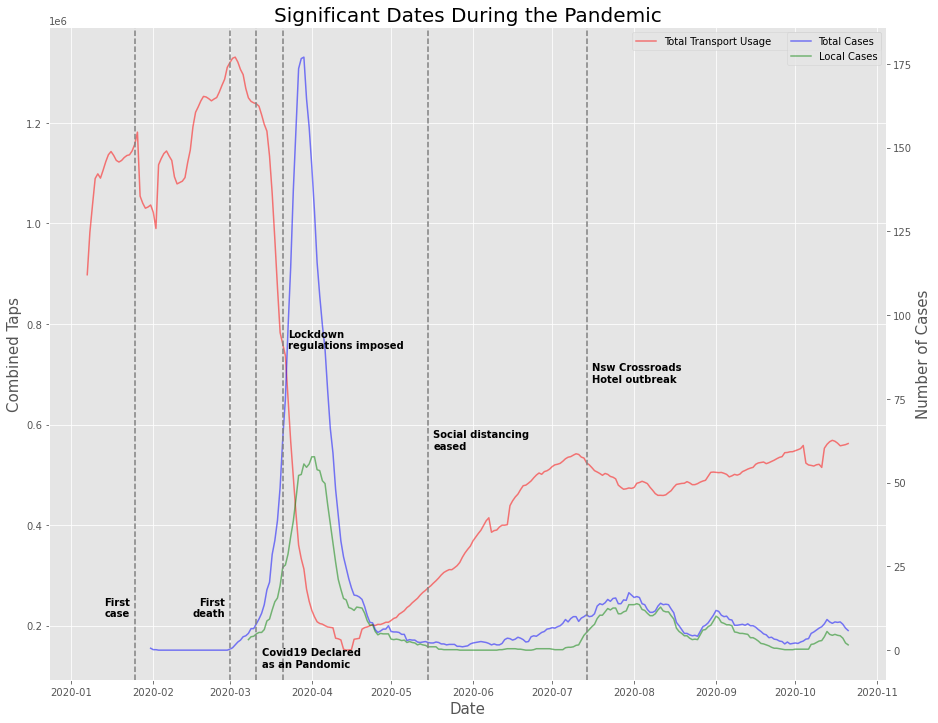

In [57]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title("Significant Dates During the Pandemic", fontsize=20)
sns.lineplot(x='date', y='combined_taps',alpha=0.5,data=smoothed_total_opal,sort=False,ci=False,legend="full", label="Total Transport Usage                                  ", color="red", ax=ax1) 
sns.lineplot(x='date', y='cases',data=smoothed_total_cases,ci=False,label="Total Cases",color="blue",alpha=0.5,ax=ax2) 
sns.lineplot(x='date', y='cases',data=smoothed_local_cases,ci=False,label="Local Cases",color="green",alpha=0.5,ax=ax2) 
ax2.grid(None)
plt.text('2020-01-23', 10, "First\ncase",fontweight='bold',ha='right')
plt.text('2020-02-28', 10, "First\ndeath",fontweight='bold',ha='right')
plt.text('2020-03-13',-5, "Covid19 Declared\nas an Pandomic",fontweight='bold',ha='left')
plt.text('2020-03-23', 90, "Lockdown\nregulations imposed",fontweight='bold',ha='left')
plt.text('2020-05-17', 60, "Social distancing\neased",fontweight='bold',ha='left')
plt.text('2020-07-16', 80, "Nsw Crossroads\nHotel outbreak",fontweight='bold',ha='left')
plt.axvline(x='2020-01-25', linestyle='--',color='gray')
plt.axvline(x='2020-03-11', linestyle='--',color='gray')
plt.axvline(x='2020-03-01', linestyle='--',color='gray')
plt.axvline(x='2020-03-21', linestyle='--',color='gray')
plt.axvline(x='2020-05-15', linestyle='--',color='gray')        
plt.axvline(x='2020-07-14', linestyle='--',color='gray')    
ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Combined Taps',fontsize=15)
ax2.set_ylabel('Number of Cases',fontsize=15)
plt.show()

From this graph, we can see some interesting trends in the data. Firstly, when the first case was reported there has been a slight dip in the usage of public transport. However, the usage of public transport starts falling massively only after the first death due to covid 19. With the rise of the number of covid cases and covid 19 being declared as a pandemic by the WHO we can see the usage of public transport declining severely.

It is interesting to note that that public transport was already declining rapidly before lockdown regulations were imposed by the government. However, the enforcement of these regulations too must have lead to a further decline in public transport usage. 

Public transport is at its minimum towards the middle of April. It is seen to rise again when the number of cases has almost hit its lowest and with the easing of social distance rules by the government this rise is further strengthened. Towards the middle of July, we can see another dip in the usage of transport with the crossroads hotel breakout in NSW. The relative use of public transport has been increasing very slightly from then onwards.


### Analysis into which region had the greatest decrease in public transport usage

In [15]:
#Adding new column to opal data that looks at relative changes in transport usage
grouped_opal['max_taps_for_region'] = grouped_opal.groupby(['region','mode_type'])['combined_taps'].transform('max')
grouped_opal['Proportion_taps'] = grouped_opal.apply(lambda row: round((row.combined_taps / row.max_taps_for_region)*100, 2), axis=1)

In [16]:
#New dataframe contianing columns needed for further exploration differences between public transport usage by region
relative_taps = grouped_opal[['date', 'mode_type', 'region', 'Proportion_taps']]
region_df = relative_taps.groupby(['date','region']).mean()
region_df.reset_index(inplace=True)

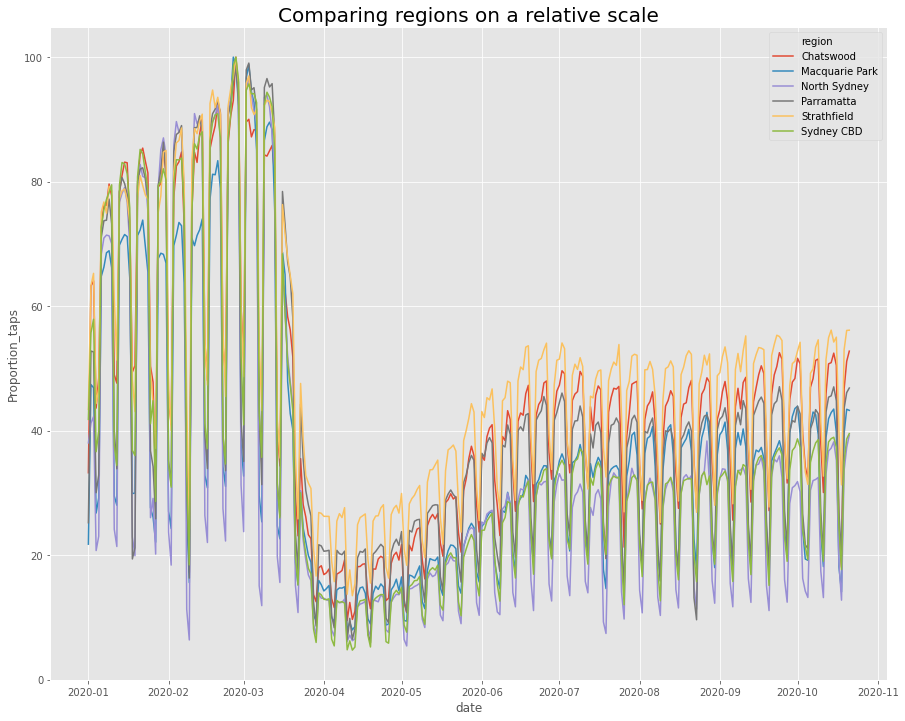

In [17]:
plt.title("Comparing regions on a relative scale", fontsize=20)
sns.lineplot(x='date', y='Proportion_taps',data=region_df, hue='region',ci=False) 
plt.show()

Here we start to see a clearer picture of what has been going on during the pandemic. This graph compares the relative proportion of public transport usage for each day in comparison to the max number of tap ons during the reported period for each area. Here we can start to see that strathfield appears to have one of the lowest changes in public transport usage as indicated by the yellow line. The noise of the graph is created by the sharp decreases in public tranport usage over the weekends which is elimnated in subsequent graphs. 

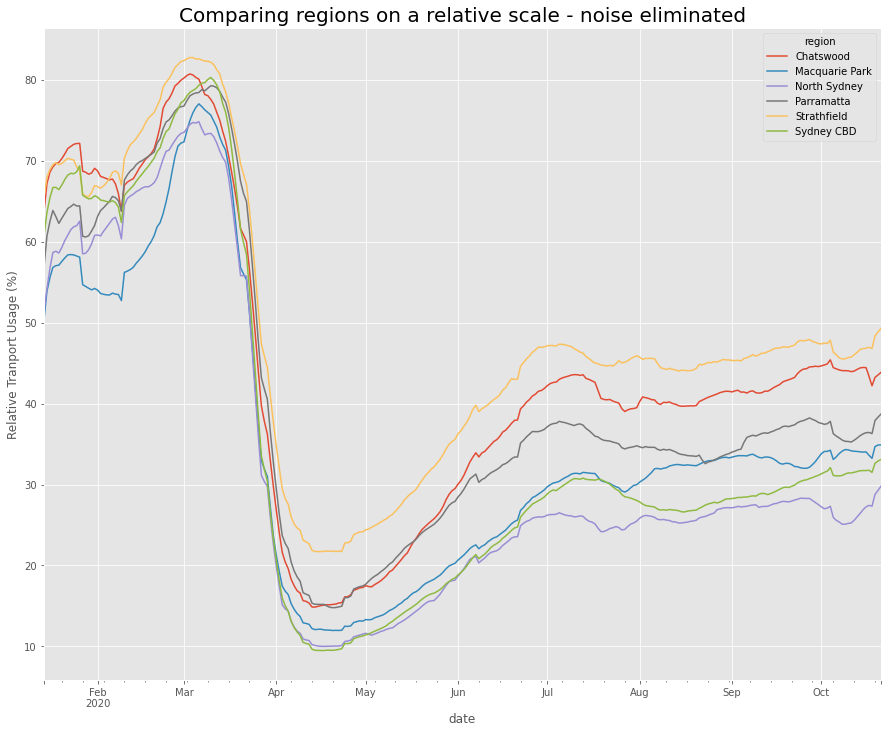

In [18]:
#Creating new dataframe for smoothed graph that averages out over the previous 14 day period
smoothed_region_df = region_df.groupby(['date', 'region']).sum()['Proportion_taps'].unstack().rolling(window=14).mean()
smoothed_region_df.dropna(inplace=True)

smoothed_region_df.plot().set_ylabel('Relative Tranport Usage (%)')
plt.title("Comparing regions on a relative scale - noise eliminated", fontsize=20)
plt.show()

Here we can can see a cleaner picture once the noise has been eliminated. We can see more clearly that the CBD has seen one of the sharpest decreases in plublic transport usage and continues to do so despite decreases in the number of reported cases throughout Australia. One of the reasons for this continued decrease could be due to bigger buisness that operate in the CBD are still allowing their employee's to be working from home. 

#### Looking into the lull period of transport usage
Here we create a new dataframe to look specifically at the differences of transport usage over the period where transport usage appears to be at its worst. We have defined this period from 01-04-2020 through to 01-07-2020. 

In [22]:
#Looking at the difference in regions over the lull period
mask1 = (region_df['date'] > '2020-04-01') & (region_df['date'] <= '2020-07-01')
lull_region = region_df.loc[mask1]

In [23]:
#Specifically looking at the averages of proportion of taps ons for different regions
lull_region.groupby('region').mean().sort_values(by='Proportion_taps')

,Proportion_taps
region,
North Sydney,17.078462
Sydney CBD,17.694835
Macquarie Park,19.261154
Parramatta,25.532308
Chatswood,27.070385
Strathfield,33.205275


Here we can see that North Sydney has averaged the lowest number of of users in comparison to it's peak earlier in the year. In comparison we see that strathfield has average the highest average of users in comparison to it's peak earlier in the year. The reasons for this are explorted in more detail in sections below. 

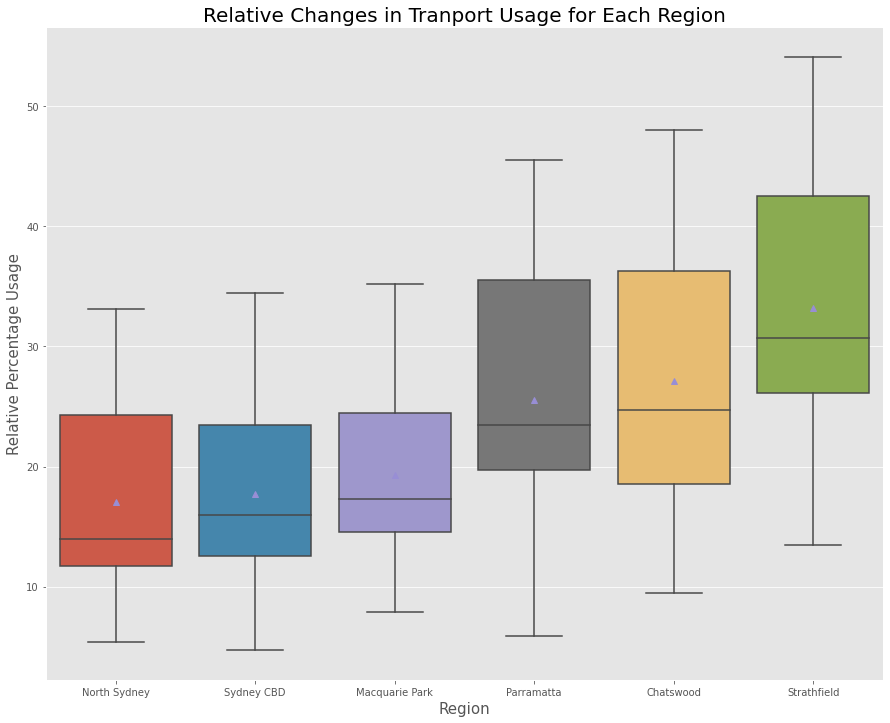

In [37]:
sns.boxplot(x="region", y="Proportion_taps", data=lull_region, order=['North Sydney', 'Sydney CBD', 'Macquarie Park', 'Parramatta', 'Chatswood', 'Strathfield'],showmeans=True)
plt.title("Relative Changes in Tranport Usage for Each Region", fontsize=20)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Relative Percentage Usage', fontsize=15)
plt.show()

Here we can see a visual representation of the relative transport usage averages and range over the lull period. We can see clear difference between each region with Strathfiled indeed having the highest average number of usage and North Sydney having the least. 

Text(0, 0.5, 'Relative Percentage Usage')

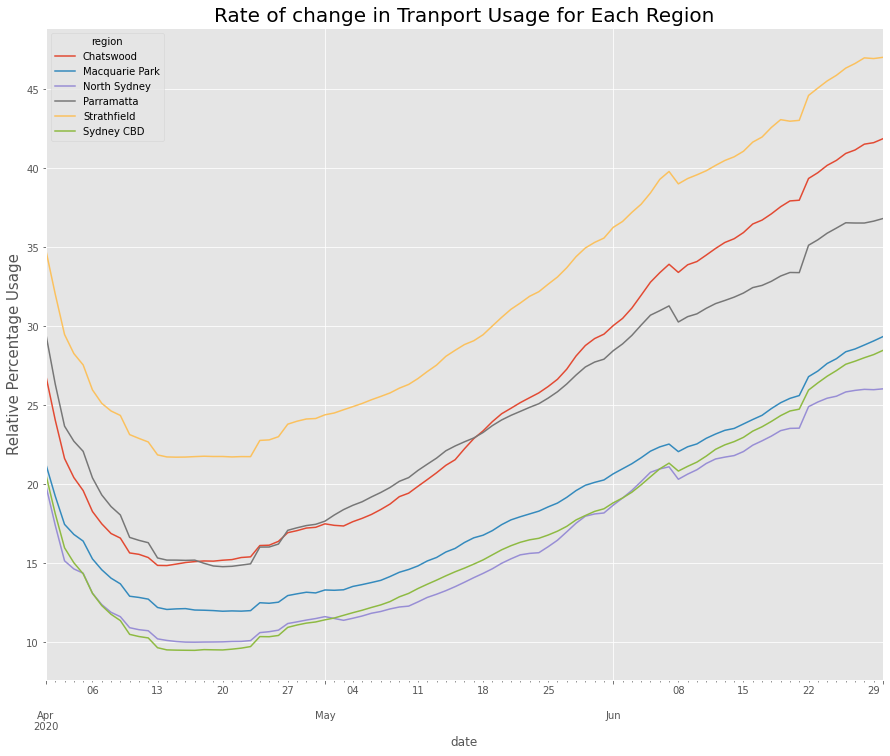

In [39]:
#Graphing the lull period difference
smoothed_region_lull = smoothed_region_df[(smoothed_region_df.index >= '2020-04-01') &
                                          (smoothed_region_df.index < '2020-07-01')]
smoothed_region_lull.plot()
plt.title("Rate of change in Tranport Usage for Each Region", fontsize=20)
plt.ylabel('Relative Percentage Usage', fontsize=15)

Here is another way of viewing the the change in relative percentage of usage for each region. It can be seen that each region has had similar rate in change of transport usage whic his something the previous graph does not show. 

### Analysis into which mode of public transport had a greater decrease in usage
Another of our project proposal goals was to identify which form of public transport (buses or trains) were affected the most from the pandemic. Thus in this segment, we will look into the Opal data and explore relationships between Buses and Trains to come to a conclusion about this goal.

Creating a data frame that groups the relative proportion of taps by mode type of transport:

In [51]:
#Creating dataframe to explore differences bewteen Bus and Train
mode_type_df = relative_taps.groupby(['date','mode_type']).mean()
mode_type_df.reset_index(inplace=True)

Now we can draw a line chart for bus and train usage to compare them. Will be using rolling average to reduce noise.

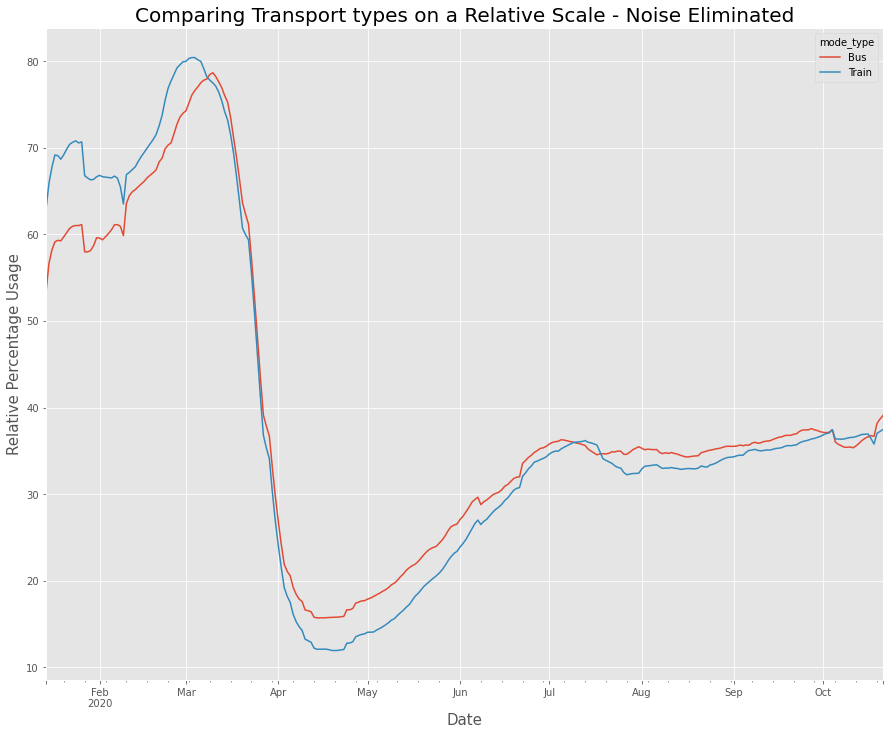

In [53]:
smoothed_mode_type_df = mode_type_df.groupby(['date', 'mode_type']).sum()['Proportion_taps'].unstack().rolling(window=14).mean()
smoothed_mode_type_df.dropna(inplace=True)
smoothed_mode_type_df.plot()
plt.title("Comparing Transport types on a Relative Scale - Noise Eliminated", fontsize=20)
plt.ylabel('Relative Percentage Usage', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

In this graph, we can see the relative changes in transport usage dependant upon the mode of transport. This graph has already been cleaned to reduce the noise from changes in transport used during the weekend. 

Although transport by train is higher before the drastic drop in transport usage we can see both types of transport follow similar patterns of rising and falling. However, from this graph, we can see there is indeed a difference between the two modes of transport, particularly around the lull period from 01-04-2020 to 01-07-2020. Investigating this lull period more closely will help to identify other relationships if any and strengthen our analysis as a whole.

#### Exploring the differences in transport types during the lull period

Drawing a line graph of public transport and their types during the lull period:

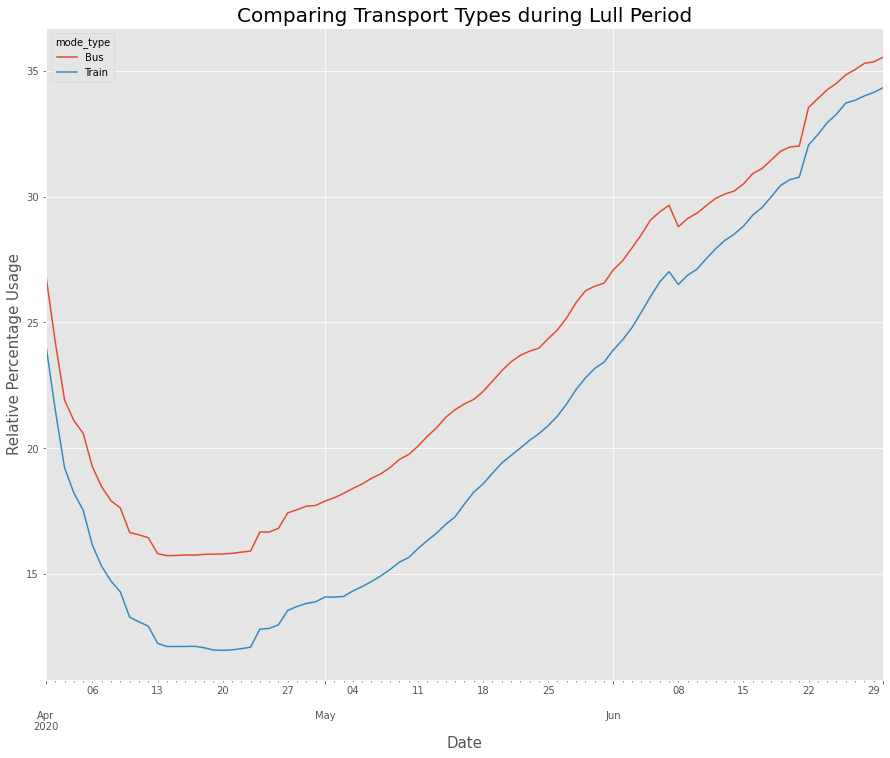

In [47]:
#Closer look at smooth lull period for mode type
smoothed_mode_type_lull = smoothed_mode_type_df[(smoothed_mode_type_df.index >= '2020-04-01') & (smoothed_mode_type_df.index < '2020-07-01')]
smoothed_mode_type_lull.plot()
plt.title("Comparing Transport Types during Lull Period", fontsize=20)
plt.ylabel('Relative Percentage Usage', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

Above graph further helps to show that the relative use of Buses remained greater than Trains. The greatest difference between them is shown towards the middle of April where usage of transport is at its lowest.

Isolating the transport data during the lull period to a new data frame to explore it more closely.

In [65]:
#Creating date range to magnify the lull period for mode type
mask2 = (mode_type_df['date'] > '2020-04-01') & (mode_type_df['date'] <= '2020-07-01')
lull_mode_type = mode_type_df.loc[mask2]

Calculating the mean proportion of taps for Buses and Trains:

In [66]:
#Looking at the averages of the proportion of taps for different transport types
lull_mode_type.groupby('mode_type').mean()

,Proportion_taps
mode_type,
Bus,24.788626
Train,21.825513


From this quick overview of the average relative proportion of transport used for each mode type we can see that Buses had a maintained a higher relative usage over the defined lull period. The reasons for such a result could likely be due to buses being more readily needed for small essential travel around local areas to allow people to get their groceries, or perhaps people felt safer travelling on a bus over using a train. 

To further analyse differences during lull period for transport types we can draw box plots of Buses and Trains:

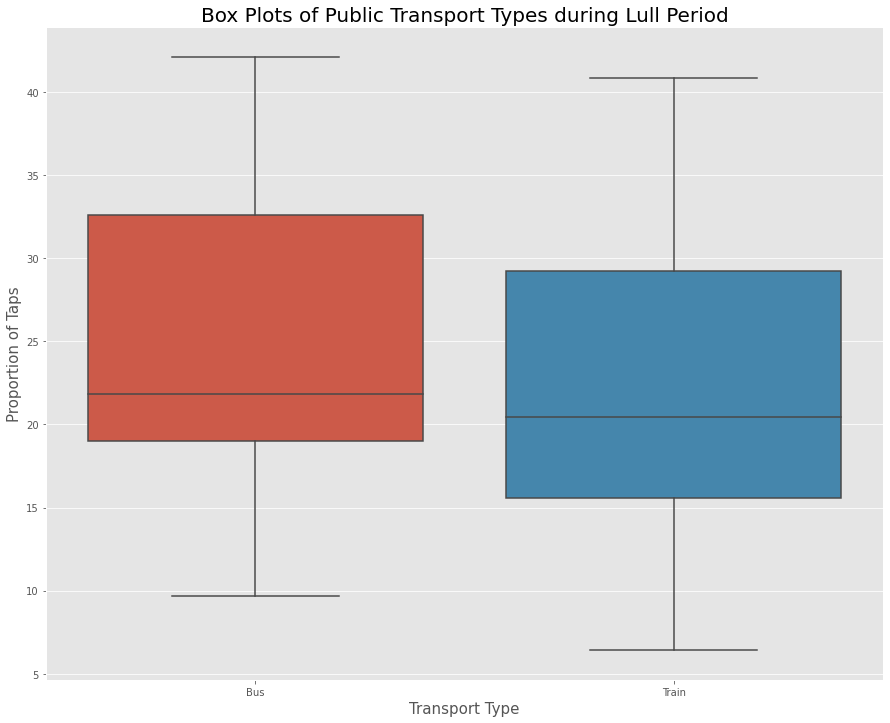

In [55]:
sns.boxplot(x="mode_type", y="Proportion_taps", data=lull_mode_type)
plt.title("Box Plots of Public Transport Types during Lull Period", fontsize=20)
plt.xlabel('Transport Type', fontsize=15)
plt.ylabel('Proportion of Taps', fontsize=15)
plt.show()

From these box plots we can identify several points:
* The medium of Proportion Taps for Buses is greater than Trains
* The minimum and maximum of proportion Taps is greater for Buses than Trains
* Bus data is more positively skewed than Train data

Overall, we can use all of the analysed charts to conclude that although both types of public transport were affected by covid 19, transport by train is more severely affected in comparison. Especially during the lull period where we see the greatest decrease in transport usage.

### Comparing Socio Economic status of an Area to it's Public transport usage
In this section we are trying to identify a possible relationship between an area's Socio Economic status and their usage of public transport.

Using the decile scores given, intially we compared the "Index of Education and Occupation", "Index of Economic Resources" and "Index of Relative Socio-economic Advantage and Disadvantage"  of reach region to provide a ranking system and measure possible relations accordingly.
Afterwards a line plot was plotted comparing the average tap ons of each region to each other, in order to persue a relationship betweem the two variables.

In [8]:
#Import socio-economic data, Take areas that relate to transport data and groupby areas and get average scores for these areas
seifa = pd.read_csv('data/seifa_overview_data.csv')
seifa = seifa[seifa['2016 Postal Area (POA) Code'].isin(['2000', '2150', '2067', '2113','2109' , '2060','2061', '2135'])]
seifa['2016 Postal Area (POA) Code'].replace(['2000', '2150', '2067', '2113','2109' , '2060','2061', '2135'], ['CBD', 'Parramatta', 'Chatswood', 'Macquarie_Park', 'Macquarie_Park', 'North_Sydney', 'North_Sydney', 'Strathfield'], inplace = True)
seifa.rename(columns={'2016 Postal Area (POA) Code': 'Area'}, inplace = True)
seifa.drop(['Data should be used with caution - area not well represented by SA1s', 'POA crosses state or territory boundaries'], axis=1, inplace=True) 
seifa.set_index('Area', inplace = True)
seifa = seifa.astype('int')
seifa.reset_index(inplace=True)
seifa = seifa.groupby('Area').mean()

In [9]:
#Only keeping columns that contian the index score
seifa = seifa.loc[:,seifa.columns.str.contains('.1')]
seifa

,Index of Relative Socio-economic Disadvantage.1,Index of Relative Socio-economic Advantage and Disadvantage.1,Index of Economic Resources.1,Index of Education and Occupation.1
Area,,,,
CBD,4.0,9.0,1.0,10.0
Chatswood,8.0,10.0,3.0,10.0
Macquarie_Park,8.0,10.0,4.0,10.0
North_Sydney,10.0,10.0,3.5,10.0
Parramatta,6.0,8.0,1.0,9.0
Strathfield,7.0,9.0,4.0,9.0


In [10]:
#Renaming columns
seifa.rename(columns={'Index of Relative Socio-economic Disadvantage.1': 'Relative SE Dis', 'Index of Relative Socio-economic Advantage and Disadvantage.1':'Relative SE Adv & Dis'}, inplace = True)
seifa

,Relative SE Dis,Relative SE Adv & Dis,Index of Economic Resources.1,Index of Education and Occupation.1
Area,,,,
CBD,4.0,9.0,1.0,10.0
Chatswood,8.0,10.0,3.0,10.0
Macquarie_Park,8.0,10.0,4.0,10.0
North_Sydney,10.0,10.0,3.5,10.0
Parramatta,6.0,8.0,1.0,9.0
Strathfield,7.0,9.0,4.0,9.0


### Description of Each index title

#### SE disadvantage score
A low score indicates relatively greater disadvantage in general. For example, an area could have a low score if there are: 

many households with low income,
many people with no qualifications, or
many people in low skill occupations

#### Economic rescources
A low score indicates a relative lack of access to economic resources in general. For example, an area may have a low score if there are: 

many households with low income, or many households paying low rent, AND
few households with high income, or few owned homes.

#### Education and Occupation
A low score indicates relatively lower education and occupation status of people in the area in general. For example, an area could have a low score if there are: 

many people without qualifications, or many people in low skilled occupations or many people unemployed, AND
few people with a high level of qualifications or in highly skilled occupations.

In [11]:
#Looking into tap on data only to see who is using transport in the area
grouped_opal['max_taps_ons_for_region'] = grouped_opal.groupby(['region','mode_type'])['tap_on'].transform('max')
grouped_opal['Proportion_tap_ons'] = grouped_opal.apply(lambda row: round((row.tap_on / row.max_taps_ons_for_region)*100, 2), axis=1)
relative_tap_ons = grouped_opal[['date', 'mode_type', 'region', 'Proportion_tap_ons']]
region_tap_ons = relative_tap_ons.groupby(['date','region']).mean()
region_tap_ons.reset_index(inplace=True)

Text(0.5, 1.0, 'Comparing the Average Tap Ons of each region')

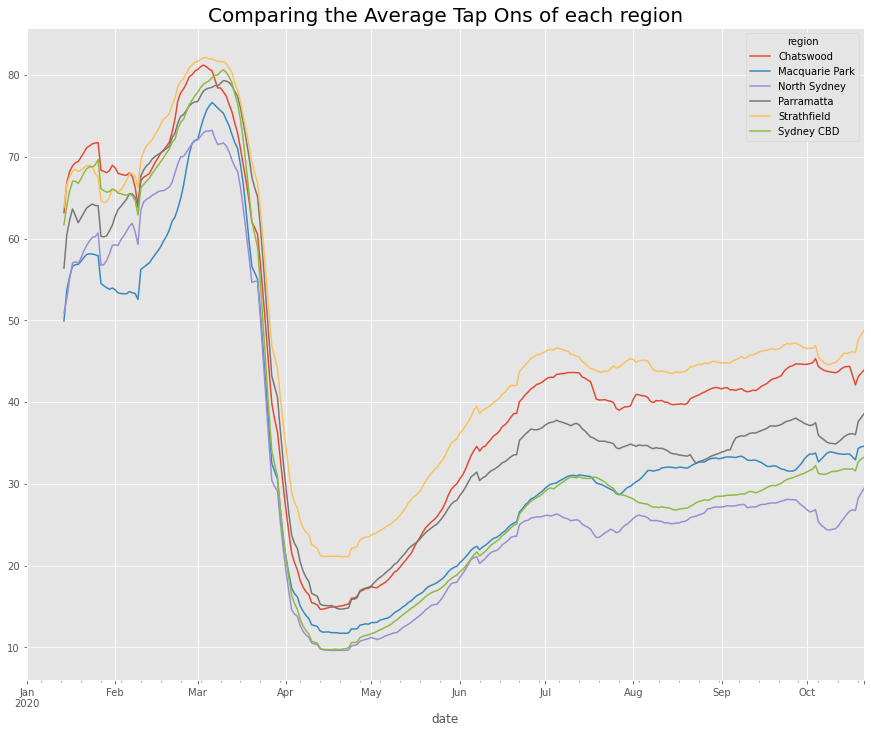

In [12]:
#Graph indicating scaled difference between taps ons in different areas
smoothed_region_tap_ons = region_tap_ons.groupby(['date', 'region']).sum()['Proportion_tap_ons'].unstack().rolling(window=14).mean()
smoothed_region_tap_ons.plot()
plt.title("Comparing the Average Tap Ons of each region", fontsize=20)

The Graph compares how the taps ons varied throughout the year for each region. It is noticable that from the mid of may there had been a massive drop in the slope until mid june where the numbers began to increase gradually. It is noticable that Strathfield and Paramatta that both had an Economic Resource Score of 4.0 had a greater rise in transport usage than per say  CBD, which had a score of 1.0. Whilst North Sydney having a score of 3.5 seemed tio have a lower transport useage than both CBD and Paramatta which have scores of 1.0.

In [19]:
smoothed_region_typical = smoothed_region_df[smoothed_region_df.index < '2020-04-01']

In [26]:
peak_usage = smoothed_region_typical.max()
minimum_usage = smoothed_region_lull.min()

relative_drop = (peak_usage - minimum_usage)/peak_usage
relative_drop

region
Chatswood         0.816140
Macquarie Park    0.844832
North Sydney      0.866469
Parramatta        0.813627
Strathfield       0.737721
Sydney CBD        0.881981
dtype: float64

In [27]:
relative_drop.rename({'Sydney CBD': 'CBD', 'Macquarie Park': 'Macquarie_Park', 'North Sydney': 'North_Sydney'}, inplace=True)

In [28]:
seifa_comparison_df = pd.DataFrame()
seifa_comparison_df['average_index'] = seifa.mean(axis=1)
seifa_comparison_df['transport_drop'] = relative_drop

In [29]:
seifa_comparison_df

,average_index,transport_drop
Area,,
CBD,6.000,0.881981
Chatswood,7.750,0.816140
Macquarie_Park,8.000,0.844832
North_Sydney,8.375,0.866469
Parramatta,6.000,0.813627
Strathfield,7.250,0.737721


Text(0.5, 1.0, 'Scatter Plot of Relative Drop In Transport Usage Against Socio-Economic Index')

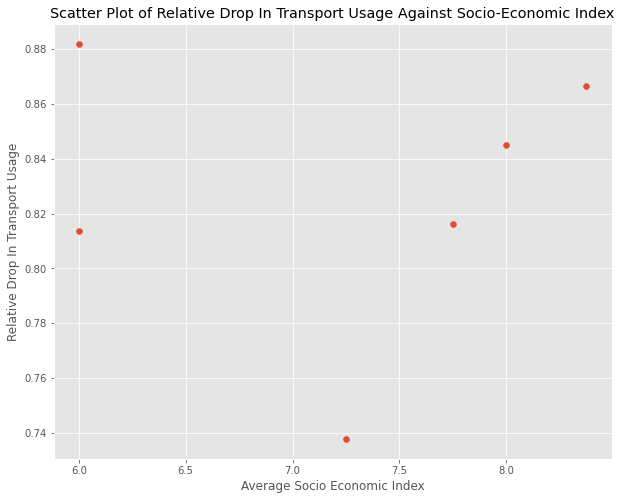

In [30]:
plt.figure(figsize=(10,8))
plt.scatter(seifa_comparison_df.average_index, seifa_comparison_df.transport_drop)
plt.xlabel('Average Socio Economic Index')
plt.ylabel('Relative Drop In Transport Usage')
plt.title('Scatter Plot of Relative Drop In Transport Usage Against Socio-Economic Index')

Looking at strathfield's average index (7.250) it had a transport drop of 0.737721, this is followed by a gradual increase in the index, going upto 7.750 in Chatwood to 8.000 in Macquarie Park and 8.375 in North Sydney, hence it is noticable that as the Socio Economic Index increases, the drop in Transport Usage had also increased. 
However Sydney CBD and Paramatta had the lowest average index, being 6.0. YET their tansport Drops are 0.881981 and 0.813627, this could be affected by anomalous data or the differance in their populations. 
There isn't enough data to complete the analysis, as we have chosen only a selected number of regions.

In [31]:
seifa_comparison_df.reset_index(inplace=True)
seifa_comparison_df1 = seifa_comparison_df[seifa_comparison_df.Area.isin(['Chatswood', 'Macquarie_Park', 'North_Sydney', 'Strathfield'])]
seifa_comparison_df1

,Area,average_index,transport_drop
1,Chatswood,7.750,0.816140
2,Macquarie_Park,8.000,0.844832
3,North_Sydney,8.375,0.866469
5,Strathfield,7.250,0.737721


Text(0.5, 1.0, 'Scatter Plot of Relative Drop In Transport Usage Against Socio-Economic Index')

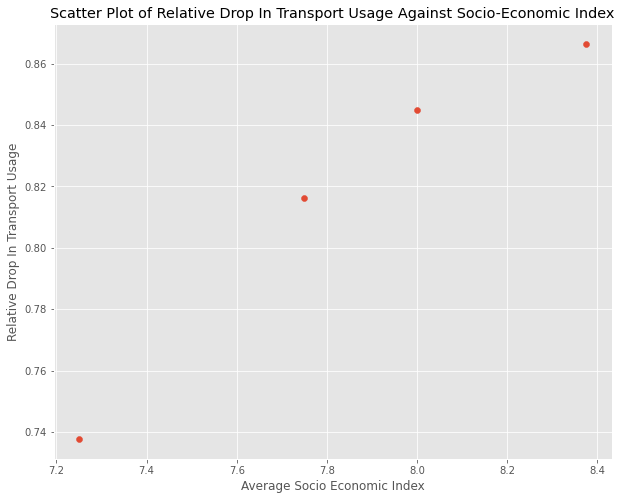

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(seifa_comparison_df1.average_index, seifa_comparison_df1.transport_drop)
plt.xlabel('Average Socio Economic Index')
plt.ylabel('Relative Drop In Transport Usage')
plt.title('Scatter Plot of Relative Drop In Transport Usage Against Socio-Economic Index')

# Conclusion and Future Improvements
To recapitulate, in our analysis we were looking into : 
- Analysing whether lockdown regulations had a negative impact on the use of public transport 
- Analysis into which mode of public transport had a greater decrease in usage over the pandemic period
- Understanding trends between different regions and looking for relationships between public transport usage and socio-economic status

When looking at lockdown regulations and its effect on transport we plotted a graph that compared the transport usage against the occurrence of other significant events. Looking at this we were able to identify that there was indeed a significant impact from these events on the use of public transport. However, the most impactful incident was when COVID-19 was announced as a pandemic on 2020/03/12 by the WHO. We also noted that public transport usage was already declining when lockdown regulations were imposed by the government but this must have further lead to the drastic decline in transport usage. 
 
Our analysis of our second goal concludes that trains were more impacted by COVID-19 compared to buses. This was especially noticeable in the lull period of lockdown which distinctly showed a great variation in their usage. We could assume the reasons for this being buses are much more suitable for shorter distances in the neighbourhood ( Supermarkets etc. ) which was perfect due to the limited commuting caused due to COVID-19. We could also assume it was due to people feeling much safer in buses compared to trains.

Finally, in our analysis of Economic Status, we were able to extract and plot a clear relationship between the variables. We could see a linear relationship between the relative drop in transport usage against the average socio-economic index. However, improvements could have been made as we were only limited to 6 stations, and 2 of which we had to remove due to anomalous results. Hence having a greater research area for this investigation would have also greatly strengthened our Conclusion, as well as being able to extract data from regions of similar population.

In conclusion, we can say that we are content in the visual analysis we carried out. We will be looking more closely at predicting the future of public transport usage using various models in our predictive analysis notebook.